In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# # check whether run in Colab
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
#     !git clone https://github.com/facebookresearch/mae.git
#     sys.path.append('./mae')
# else:
#     sys.path.append('..')
import models_mae
import models_mae_cnn
import cv2

/home/jfxiao/anaconda3/envs/mae/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
img_list_val = list()
img_list_val_labels = list()
data_dir = 'data/nih_chestxray'
with open('data_splits/chestxray/test_official.txt', "r") as fileDescriptor:
    line = True
    while line:
        line = fileDescriptor.readline()
        if line:
            lineItems = line.split()
            imagePath = os.path.join(data_dir, lineItems[0])
            imageLabel = lineItems[1:14 + 1]
            imageLabel = [int(i) for i in imageLabel]
            img_list_val.append(imagePath)
            img_list_val_labels.append(imageLabel)
img_list_val

['data/nih_chestxray/00000003_000.png',
 'data/nih_chestxray/00000003_001.png',
 'data/nih_chestxray/00000003_002.png',
 'data/nih_chestxray/00000003_003.png',
 'data/nih_chestxray/00000003_004.png',
 'data/nih_chestxray/00000003_005.png',
 'data/nih_chestxray/00000003_006.png',
 'data/nih_chestxray/00000003_007.png',
 'data/nih_chestxray/00000013_000.png',
 'data/nih_chestxray/00000013_001.png',
 'data/nih_chestxray/00000013_002.png',
 'data/nih_chestxray/00000013_003.png',
 'data/nih_chestxray/00000013_004.png',
 'data/nih_chestxray/00000013_005.png',
 'data/nih_chestxray/00000013_006.png',
 'data/nih_chestxray/00000013_007.png',
 'data/nih_chestxray/00000013_008.png',
 'data/nih_chestxray/00000013_009.png',
 'data/nih_chestxray/00000013_010.png',
 'data/nih_chestxray/00000013_011.png',
 'data/nih_chestxray/00000013_012.png',
 'data/nih_chestxray/00000013_013.png',
 'data/nih_chestxray/00000013_014.png',
 'data/nih_chestxray/00000013_015.png',
 'data/nih_chestxray/00000013_016.png',


In [9]:
def load_img_gray(path, size=224, mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])):
    img = Image.open(path).convert('RGB')
    img = img.resize((size, size))
    img = np.array(img) / 255.
    assert img.shape == (size, size, 3)
    # normalize by ImageNet mean and std
    img = img - mean
    img = img / std
    return img


chestxray_mean = np.array([0.5056, 0.5056, 0.5056])
chestxray_std = np.array([0.252, 0.252, 0.252])

def show_image(image, title='', mean=chestxray_mean, std=chestxray_std):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * std + mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
#     print(title,'min:', image.min().item(),'max:', image.max().item())
#     print(title,'mean:', image.mean().item(),'std:',  image.std().item())
    return torch.clip((image * std + mean) * 255, 0, 255).numpy().astype(np.uint8)

<All keys matched successfully>
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
0.044882126
0.044882126


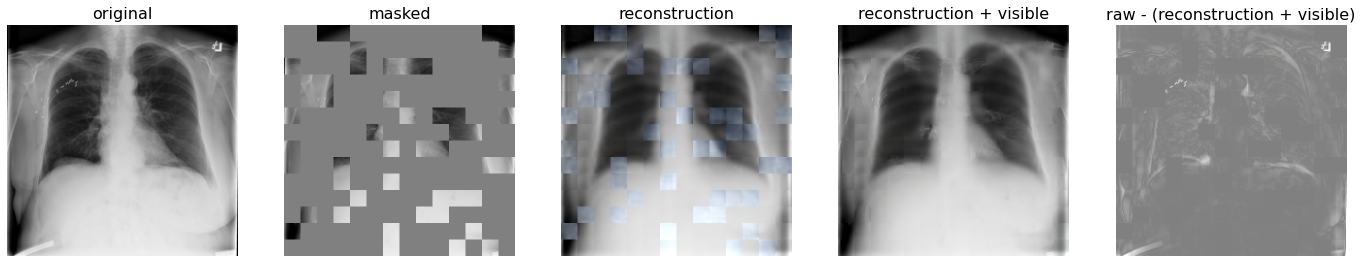

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
0.053492893
0.053492893


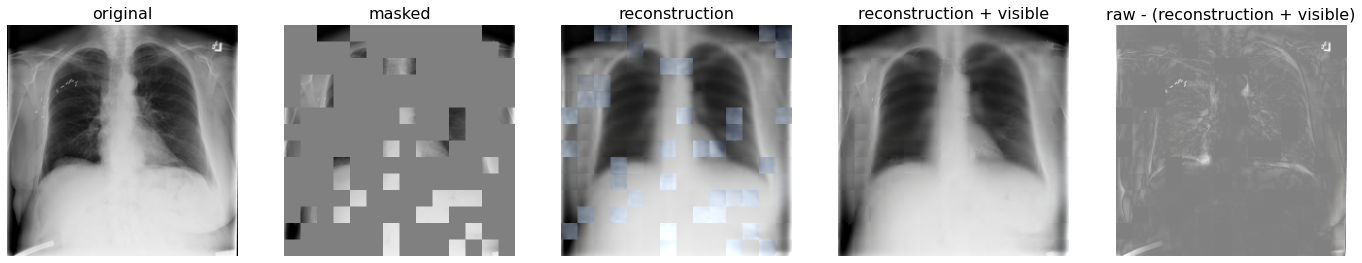

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
0.057280626
0.057280626


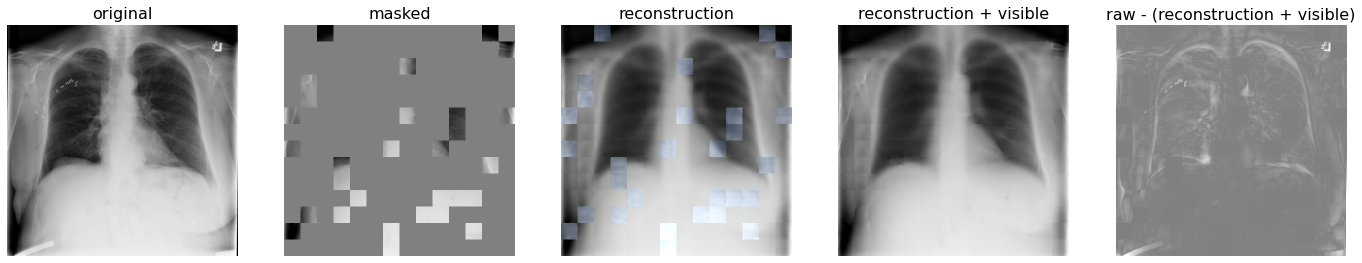

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
0.068935044
0.068935044


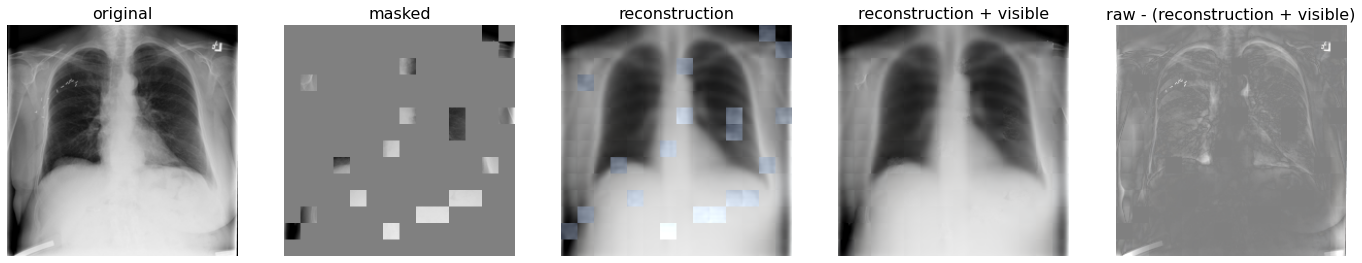

In [21]:
def prepare_model(chkpt_dir, arch='mae_vit_large_patch16',heatmap=None, mask_strategy='random'):
    # build model
    model = getattr(models_mae, arch)(heatmap=heatmap, mask_strategy=mask_strategy)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def pick_best_image_over_runs(img, model, mask_ratio=0.75, run=1):


    # run MAE
    lowest_loss = 100
    for seed in range(run):
        x = torch.tensor(img)

        # make it a batch-like
        x = x.unsqueeze(dim=0)
        x = torch.einsum('nhwc->nchw', x)
        torch.manual_seed(seed)
        loss, y, mask = model(x.float(), mask_ratio=mask_ratio)
        if loss.detach().numpy().item() < lowest_loss:
            lowest_loss = loss.detach().numpy().item()
            best_seed = seed
        print(loss.detach().numpy())
    
    x = torch.tensor(img)
    torch.manual_seed(best_seed)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio)
    print(loss.detach().numpy())
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 5, 1)
    img_original = show_image(x[0], "original")

    plt.subplot(1, 5, 2)
    img_masked = show_image(im_masked[0], "masked")

    plt.subplot(1, 5, 3)
    img_reconstruction = show_image(y[0], "reconstruction")
    plt.subplot(1, 5, 4)
    img_paste = show_image(im_paste[0], "reconstruction + visible")
    plt.subplot(1, 5, 5)
    show_image(torch.abs(x[0] - im_paste[0]), "raw - (reconstruction + visible)")
    plt.show()
    return [img_original, img_masked, img_paste]


# img_from_val_path = 'data/nih_chestxray/00000087_000.png'
chkpt_dir = './work_dirs/pretrain_exp67_chexpert_nih_vit_small_800e_224_mask90_random_RRC_bs2048_e1/checkpoint-799.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_small_patch16_dec512d2b', heatmap=None)
i = 3
for mask_ratio_percentage in [75, 80, 85, 90]:
    img_from_val_path = img_list_val[i]
    print(img_list_val_labels[i])
    img_from_val = load_img_gray(img_from_val_path, size=224, mean=chestxray_mean, std=chestxray_std)
    img_original, img_masked, img_paste = pick_best_image_over_runs(img_from_val, model_mae, mask_ratio=0.01 * mask_ratio_percentage, run=1)

    plt.imsave(f'figures/vit-s_masked_input_mask{mask_ratio_percentage}_img{i}.png', img_masked)
    plt.imsave(f'figures/vit-s_reconstruction_mask{mask_ratio_percentage}_img{i}.png', img_paste)


In [58]:
from matplotlib.pyplot import cm

<All keys matched successfully>
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
0.10695679
0.10695679
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


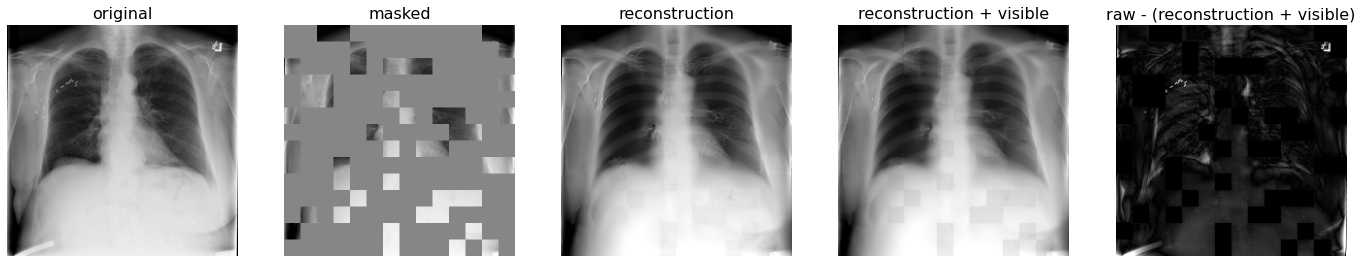

(224, 224)
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
0.17671768
0.17671768
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


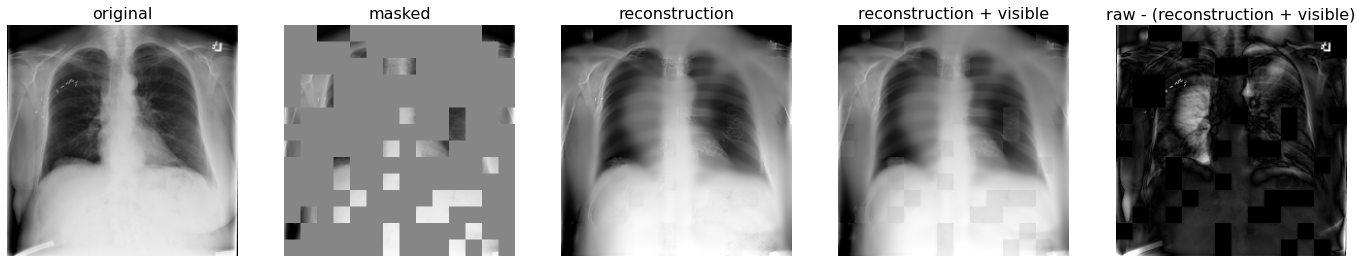

(224, 224)
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
0.33819684
0.33819684
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


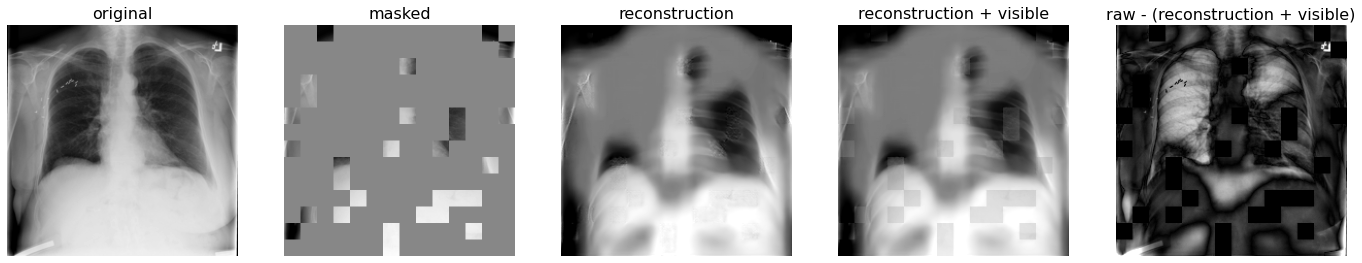

(224, 224)
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
0.58398217
0.58398217
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


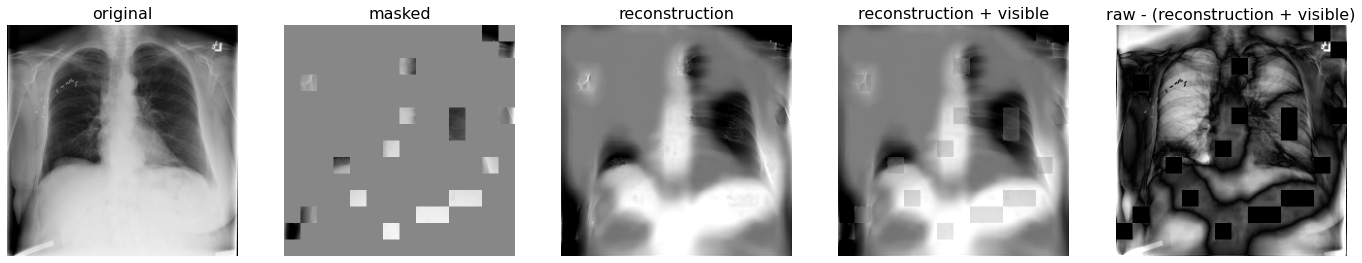

(224, 224)


In [59]:
def prepare_model_cnn(chkpt_dir, model_arch='Unet', encoder_model='densenet121'):
    # build model
    model = models_mae_cnn.MaskedAutoencoderCNN(img_size=224, patch_size=16, model_arch='Unet', encoder_name=encoder_model)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def show_image(image, title='', mean=chestxray_mean, std=chestxray_std):
    # image is [H, W, 3]
    assert image.shape[2] == 3

    plt.imshow(torch.clip((image * std + mean) * 255, 0, 255).int()[:,:,0], cmap='gray')
    plt.title(title, fontsize=16)
    plt.axis('off')
#     print(title,'min:', image.min().item(),'max:', image.max().item())
#     print(title,'mean:', image.mean().item(),'std:',  image.std().item())
    return torch.clip((image * std + mean) * 255, 0, 255).numpy().astype(np.uint8)[:,:,0]


def pick_best_image_over_runs(img, model, mask_ratio=0.75, run=1):


    # run MAE
    lowest_loss = 100
    for seed in range(run):
        x = torch.tensor(img)

        # make it a batch-like
        x = x.unsqueeze(dim=0)
        x = torch.einsum('nhwc->nchw', x)
        torch.manual_seed(seed)
        loss, y, mask = model(x.float(), mask_ratio=mask_ratio)
        if loss.detach().numpy().item() < lowest_loss:
            lowest_loss = loss.detach().numpy().item()
            best_seed = seed
        print(loss.detach().numpy())
    
    x = torch.tensor(img)
    torch.manual_seed(best_seed)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio)
    print(loss.detach().numpy())
    print(x.shape)
    mask = mask.unsqueeze(-1).repeat(1, 1, 16**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    print(mask.shape)
    print(y.shape)
#     y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
#     x_masked = self.unpatchify(x * (1 - mask.unsqueeze(-1)))

#     mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
#     mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
#     mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 5, 1)
    img_original = show_image(x[0], "original")

    plt.subplot(1, 5, 2)
    img_masked = show_image(im_masked[0], "masked")

    plt.subplot(1, 5, 3)
    img_reconstruction = show_image(y[0], "reconstruction")
    plt.subplot(1, 5, 4)
    img_paste = show_image(im_paste[0], "reconstruction + visible")
    plt.subplot(1, 5, 5)
    show_image(torch.abs(x[0] - im_paste[0]), "raw - (reconstruction + visible)")
    plt.show()
    return [img_original, img_masked, img_paste]


# img_from_val_path = 'data/nih_chestxray/00000087_000.png'
chkpt_dir = './work_dirs/pretrain_exp74_chexpert_nih_densenet121_unet_800e_224_mask75_random_RRC_bs2048_fixed_e1/checkpoint-799.pth'
model_mae = prepare_model_cnn(chkpt_dir, model_arch='Unet', encoder_model='densenet121')
i = 3
for mask_ratio_percentage in [75, 80, 85, 90]:
    img_from_val_path = img_list_val[i]
    print(img_list_val_labels[i])
    img_from_val = load_img_gray(img_from_val_path, size=224, mean=chestxray_mean, std=chestxray_std)
    img_original, img_masked, img_paste = pick_best_image_over_runs(img_from_val, model_mae, mask_ratio=0.01 * mask_ratio_percentage, run=1)
    print(img_masked.shape)
    plt.imsave(f'figures/densenet121_masked_input_mask{mask_ratio_percentage}_img{i}.png', img_masked, cmap=cm.gray)
    plt.imsave(f'figures/densenet121_reconstruction_mask{mask_ratio_percentage}_img{i}.png', img_paste, cmap=cm.gray)

# plt.imshow(result_img)
#     plt.imsave(f'figures/reconstruction_mask75_img{i}.png', result_img)
    
# chkpt_dir = './work_dirs/pretrain_exp43_chestxray_vit_small_200e_224_mask80_SA_mean_fixed_RRC_e1/checkpoint-199.pth'
# model_mae = prepare_model(chkpt_dir, 'mae_vit_small_patch16_dec512d2b', heatmap=None, mask_strategy='self_attention_mean')
# for i in range(1,5):
#     img_from_val_path = img_list_val[i]
#     print(img_list_val_labels[i])
#     img_from_val = load_img_gray(img_from_val_path, size=224, mean=chestxray_mean, std=chestxray_std)
#     result_img = pick_best_image_over_runs(img_from_val, model_mae, mask_ratio=0.80, run=5)
#     plt.imsave(f'figures/reconstruction_mask80_img{i}.png', result_img)


# chkpt_dir = './work_dirs/pretrain_exp42_chestxray_vit_small_200e_224_mask85_SA_mean_fixed_RRC_e1/checkpoint-199.pth'
# model_mae = prepare_model(chkpt_dir, 'mae_vit_small_patch16_dec512d2b', heatmap=None, mask_strategy='self_attention_mean')
# for i in range(1,5):
#     img_from_val_path = img_list_val[i]
#     print(img_list_val_labels[i])
#     img_from_val = load_img_gray(img_from_val_path, size=224, mean=chestxray_mean, std=chestxray_std)
#     result_img = pick_best_image_over_runs(img_from_val, model_mae, mask_ratio=0.85, run=5)
#     plt.imsave(f'figures/reconstruction_mask85_img{i}.png', result_img)



# chkpt_dir = './work_dirs/pretrain_exp33_chestxray_vit_small_200e_224_mask90_SA_mean_fixed_RRC_e1/checkpoint-199.pth'
# model_mae = prepare_model(chkpt_dir, 'mae_vit_small_patch16_dec512d2b', heatmap=None, mask_strategy='self_attention_mean')
# for i in range(1,5):
#     img_from_val_path = img_list_val[i]
#     print(img_list_val_labels[i])
#     img_from_val = load_img_gray(img_from_val_path, size=224, mean=chestxray_mean, std=chestxray_std)
#     result_img = pick_best_image_over_runs(img_from_val, model_mae, mask_ratio=0.90, run=5)
#     plt.imshow(result_img)
#     plt.imsave(f'figures/reconstruction_mask90_img{i}.png', result_img)